### Import packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# RFE (Recursive Feature Elimination)
from sklearn.feature_selection import RFE
import datetime as dt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from scipy.linalg.decomp_svd import LinAlgError
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Functions

In [4]:
def get_data():
    """ Getting the data from either my laptop or computer, and add a couple date-related columns """
    x = input("Laptop or computer (l/c)?:")
    if x == 'l':
        os.chdir(r'C:\Codes\Cox_Manheim_analysis')
        data_dict = pd.read_excel('Case Study and Data Dictionary 201407.xlsx', sheet_name = 1, skiprows = 1)
        raw_data = pd.read_excel('transaction_data_processed.xlsx', sheet_name = 'data')
        with open(r'C:\Codes\Cox_Manheim_analysis\Case_Study.txt') as f:
            case_study = f.read()
    if x == 'c':
        os.chdir(r'C:\Users\willh\Cox_Manheim_Analysis\Car_Sales')
        data_dict = pd.read_excel(r'C:\Users\willh\Cox_Manheim_Analysis\Case Study and Data Dictionary 201407.xlsx', sheet_name = 1, skiprows = 1)
        raw_data = pd.read_excel(r'C:\Users\willh\Cox_Manheim_Analysis\Car_Sales\transaction_data_processed.xls')
        case_study = None
    # Make Date-related columns
    raw_data['DMSTDESL_DT'] = pd.to_datetime(raw_data['DMSTDESL'], format = '%Y%m%d')
    raw_data['Sale_day_name'] = raw_data['DMSTDESL_DT'].dt.weekday
    # make a column for week of month (1st week, 2nd week, 3rd week, ...)
    days = pd.DatetimeIndex(raw_data['DMSTDESL_DT'].unique())
    week_month = {}
    week = 1
    current_month = dt.datetime(2013,1,1).month
    for d in days:
    #    print(int(d.month))
        if current_month == int(d.month):
            week_month[d] = week
            week += 1
        else:
            week = 1
            current_month = int(d.month)
            week_month[d] = week
            week +=1
            
    raw_data['month_week'] = raw_data['DMSTDESL_DT'].map(week_month)
    season = pd.DataFrame({'M':[1,2,3,4,5,6,7,8,9,10,11,12],'Season':['W','W','S','S','S','Su','Su','Su','F','F','F','W']})
    raw_data = pd.merge(raw_data,season,left_on='DMMONTH',right_on='M')
    raw_data.drop('M',inplace=True,axis=1)
    raw_data['STIMES_bin2'].replace({"<10":"before 10", ">2":"after 2"}, inplace= True)
    raw_data['Arbitration_bins'].replace({"<=10":"less than 10", ">150":"greater than 150"}, inplace= True)
    raw_data = raw_data[raw_data['DMMODEL'].notnull()]
    raw_data = raw_data[raw_data['DMJDCAT'].notnull()]
    return data_dict, raw_data, case_study

In [5]:
def prep_data(data_penult, cat_cols = False, scaling = False):
    """ Prep data - make dummy variables, scale the data, split data into train and test sets """
    if cat_cols:
        # Make dummy variables
#        cat_cols = data_penult.loc[:, data_penult.columns != 'DMSOLD'].columns # use this if all columns are categorical
#        cat_cols = ['STIMESxArb', 'month_week'] # use this if columns are both categorical and continuous
        for col in cat_cols:
            cat_list='var'+'_'+col
            cat_list = pd.get_dummies(data_penult[col], prefix=col, drop_first = True)
            data1=data_penult.join(cat_list)
            data_penult=data1
        data_vars=data_penult.columns.values.tolist()
        to_keep=[i for i in data_vars if i not in cat_cols]
        # final data columns will be:
        data_final=data_penult[to_keep]
#        data_final.columns.values
    else:
        data_final = data_penult
    # Make X and y datasets
    X = data_final.drop(['DMSOLD'], axis = 1)
    y = data_final.DMSOLD 
    #X = X.values
    if scaling:
        # scale the data - If dataset has continuous variables
        x_index = X.index
        x_cols = X.columns        
        sc_X = StandardScaler()
        X = sc_X.fit_transform(X)
        X = pd.DataFrame(data=X, index = x_index, columns=x_cols)
        #scaled_X = pd.DataFrame(data = scaled_X, columns = X.columns.tolist())        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    return X_train, X_test, y_train, y_test

In [6]:
def get_model_results(X_train, y_train, X_test, y_test):
    """ Run data through models to see scores, confusion matrices, and important features """
    # Spot Check Algorithms
    # evaluate each model in turn
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
#    models.append(('LDA', LinearDiscriminantAnalysis()))
    #models.append(('KNN', KNeighborsClassifier()))
#    models.append(('CART', DecisionTreeClassifier()))
#    models.append(('NB', GaussianNB()))
    #    models.append(('SVM', SVC(gamma='auto')))
    models.append(('XGB', XGBClassifier()))
    models.append(('RF', RandomForestClassifier()))

    results = []
    names = []
    initial_all_results = {}
    columns = {}
    cm_dict = {}
    scores_dict = {}
#    feature_importances = {}
    prec_rec = {}
    print("Running initial models")
    for name, model in models:
        try:
            timenow = dt.datetime.now()
            print("Running initial "+name)
            kfold = StratifiedKFold(n_splits=10, random_state=1)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')        
            results.append(cv_results)
            names.append(name)
            initial_all_results[name] = [cv_results.mean(),cv_results.std()]
            print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
            classifier = model
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            print(cm) 
            cm_dict[name] = cm
            score = classifier.score(X_test, y_test)
            print("score:" + str(score))
            scores_dict[name] = score
            prec_score = precision_score(y_test,y_pred)
            rec_score = recall_score(y_test, y_pred)
            prec_rec[name] = [prec_score, rec_score]
            print("prec_rec: ", prec_score, rec_score)
            if name not in ['CART','RF','NB','XGB']:
                coef = classifier.coef_
                abs_coef = abs(coef)
                sorted_index = np.argsort(abs_coef)
        #        sorted_coef = abs_coef[sorted_index]
                sorted_cols = X_test.columns[sorted_index]
                columns[name] = sorted_cols
            elif name in ['CART','NB']:
                continue
            else:
                importances = classifier.feature_importances_
                indices = np.argsort(importances)[::-1]
                
                feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": importances}).sort_values("Importance", ascending=False)
        except LinAlgError:
            print("LinAlgError: SVD did not converge")
#        coef_dict = {k:v for (k,v) in zip(sorted_cols, sorted_coef)}
#        print(sorted_cols)
#        coefs = pd.DataFrame(coef_dict)
#        acc_score = classifier.accuracy_score(y_test, y_pred)
#        print("acc_score:" + str(acc_score))
#    # Compare Algorithms
#    pyplot.boxplot(results, labels=names)
#    pyplot.title('Algorithm Comparison')
#    pyplot.show()
    
    return initial_all_results, cm_dict, scores_dict, columns, feature_importances, prec_rec

In [7]:
def rfe_feature_selection(X_train, y_train):
    models = []
#    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
#    models.append(('LDA', LinearDiscriminantAnalysis()))
    #models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
#    models.append(('NB', GaussianNB()))
    #    models.append(('SVM', SVC(gamma='auto')))
#    models.append(('XGB', XGBClassifier()))
    models.append(('RF', RandomForestClassifier()))
    rfe_columns = {}
    for name, model in models: 
        rfe = RFE(model, 10)
        rfe = rfe.fit(X_train, y_train)
        print(rfe.support_)
        print(rfe.ranking_)
    
        indices = [i for i, x in enumerate(rfe.ranking_) if x == 1]
        cols = X_train.iloc[:,indices].columns
        #rfe_columns[model] = cols
    return cols

In [8]:
def grid_search(X_train, y_train):    
    """ Run grid searches on models to find the best hyperparameters """
    gridsearch_results = {}
# Grid Search XGBoost
    print("Running XGB Grid Search")
    XGBclassifier = XGBClassifier()
    XGBparameters = [{'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.03, 0.05, 0.1]}]
    XGBgrid_search = GridSearchCV(estimator = XGBclassifier,
                               param_grid = XGBparameters,
                               scoring = 'accuracy',
                               cv = 10,
                               n_jobs = -1)
    XGBgrid_search = XGBgrid_search.fit(X_train, y_train)
    XGBbest_accuracy = XGBgrid_search.best_score_
    XGBbest_parameters = XGBgrid_search.best_params_
    gridsearch_results['XGB'] = [XGBbest_accuracy, XGBbest_parameters]
    print("Completed running all grid search")
    
    # Grid Search Random Forest
    print("Running RF Grid Search")
    RFclassifier = RandomForestClassifier()
    RFparameters = [{'n_estimators': [10, 20, 40, 60],'criterion': ['gini','entropy']}]
    RFgrid_search = GridSearchCV(estimator = RFclassifier,
                               param_grid = RFparameters,
                               scoring = 'accuracy',
                               cv = 10,
                               n_jobs = -1)
    RFgrid_search = RFgrid_search.fit(X_train, y_train)
    RFbest_accuracy = RFgrid_search.best_score_
    RFbest_parameters = RFgrid_search.best_params_
    gridsearch_results['RF'] = [RFbest_accuracy, RFbest_parameters]
    print("Completed running all grid search")
    
    return gridsearch_results

In [9]:
def top10Correl(col='DMSOLD'):
    '''
    find the most correlated features with target column
    '''
    correlatedWTarg = []
    for i in data.columns:      
        if i == col:
            continue
        else:
            correlation = pd.DataFrame(data[[col,i]].corr())
            try:
                if correlation[col][1] < 0:
                    correlatedWTarg.append(tuple([i,abs(correlation[col][1]),'neg',col]))
                else:
                    correlatedWTarg.append(tuple([i,abs(correlation[col][1]),'pos',col]))
            except:
                pass
    mostCorrel = pd.DataFrame(correlatedWTarg,columns=['IndVar','Correl','np','TarFeat'])
    mostCorrel.sort_values('Correl',ascending=False,inplace=True)
    mostCorrel.iloc[:10]
    return mostCorrel

In [23]:
# get the data
data_dict, raw_data, case_study = get_data()        

Laptop or computer (l/c)?:c


In [24]:
# Make copy of data
data = raw_data.copy()

In [25]:
data.isnull().sum()

DMSTDESL                0
DMMONTH                 0
DMSALWK                 0
SSALE_                  0
SLANE_                  0
SRUN_                   0
STIMES                  0
imp_STIMES              0
STIMES_bin              0
STIMES_bin2             0
STIMES_bin3             0
DMTRANTYPE          25275
DMSOLD                  0
DMOPCSUID               0
DMSELLRNM               0
SFLOOR              45691
DMMODELYR               0
DMMODELYR_bins          0
DMMAKE                  0
DMMODEL                 0
DMBODY                  0
SSER17                  0
SSLEPR                  0
SMILES                  0
DMJDCAT                 0
AGEDDAYS                0
DMPRECOND               0
DMPOSTCOND              0
DMDETFEE                0
DMRECONFEE              0
DMECRDATE           27487
VNMMR                   0
SFLR_lower          45691
% Arbitration           0
Arbitration_bins        0
SFLOOR_IND              0
DMECRDATE_IND           0
DMSTDESL_DT             0
Sale_day_nam

###  Drop columns that are not useful or missing data

In [26]:
data.drop(columns=['SSER17','STIMES','STIMES_bin','STIMES_bin2','STIMES_bin3','DMTRANTYPE','SFLOOR','DMMODELYR_bins','SSLEPR','DMPRECOND','DMPOSTCOND','DMDETFEE','DMRECONFEE','DMECRDATE','SFLR_lower','Arbitration_bins','DMSTDESL_DT','Sale_day_name'], inplace=True)

In [27]:
data.isnull().sum()

DMSTDESL         0
DMMONTH          0
DMSALWK          0
SSALE_           0
SLANE_           0
SRUN_            0
imp_STIMES       0
DMSOLD           0
DMOPCSUID        0
DMSELLRNM        0
DMMODELYR        0
DMMAKE           0
DMMODEL          0
DMBODY           0
SMILES           0
DMJDCAT          0
AGEDDAYS         0
VNMMR            0
% Arbitration    0
SFLOOR_IND       0
DMECRDATE_IND    0
month_week       0
Season           0
dtype: int64

### Label encode categorical features

In [28]:
corr_data = data.copy()
categorical_features = ['DMOPCSUID','DMSELLRNM','DMMAKE','DMMODEL','DMBODY','DMJDCAT','SFLOOR_IND','DMECRDATE_IND','month_week','Season']
for i in categorical_features:
    encoder = LabelEncoder()
    corr_data.loc[:,i] = encoder.fit_transform(corr_data.loc[:,i])

In [29]:
corr_data.head(10)

,DMSTDESL,DMMONTH,DMSALWK,SSALE_,SLANE_,SRUN_,imp_STIMES,DMSOLD,DMOPCSUID,DMSELLRNM,...,DMBODY,SMILES,DMJDCAT,AGEDDAYS,VNMMR,% Arbitration,SFLOOR_IND,DMECRDATE_IND,month_week,Season
0,20130102,1,1,1,3,501,92831,0,569,414,...,362,58725,3,0,6725,10.7,0,1,0,3
1,20130102,1,1,1,3,502,124108,0,569,414,...,1288,75908,5,0,19950,10.7,0,1,0,3
2,20130102,1,1,1,3,503,120221,0,569,414,...,1646,53452,8,0,20500,10.7,0,1,0,3
3,20130102,1,1,1,3,504,94333,1,569,414,...,119,71126,6,2,6450,10.7,0,0,0,3
4,20130102,1,1,1,3,505,93250,1,569,414,...,950,71997,7,2,11350,10.7,0,0,0,3
5,20130102,1,1,1,3,506,93331,1,569,414,...,95,67591,6,0,8300,10.7,0,0,0,3
6,20130102,1,1,1,3,507,93420,1,569,414,...,385,139448,4,0,3175,10.7,0,0,0,3
7,20130102,1,1,1,3,508,93508,1,569,414,...,478,123780,4,0,5975,10.7,0,0,0,3
8,20130102,1,1,1,3,509,93623,1,569,414,...,1645,188502,8,0,2500,10.7,0,0,0,3
9,20130102,1,1,1,3,510,93715,1,569,414,...,482,173933,4,2,5550,10.7,0,0,0,3


### Correlations

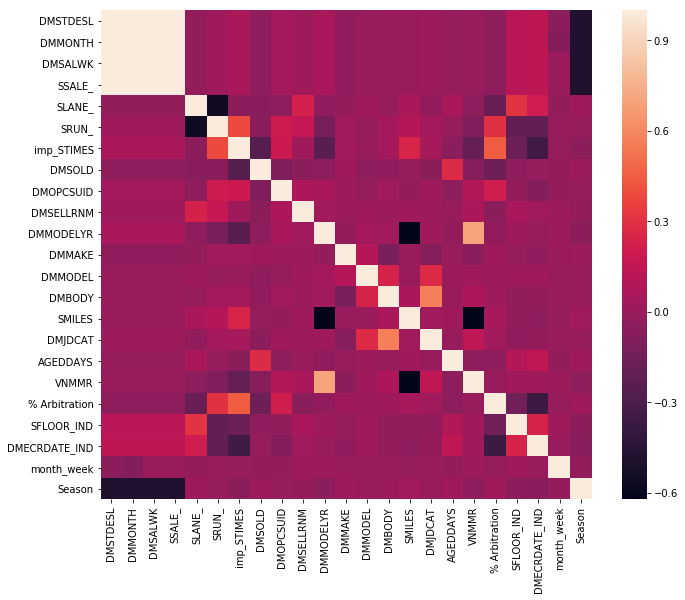

In [30]:
corr = corr_data.corr()
fig, ax = plt.subplots(figsize=(11,9))
ax = sns.heatmap(corr)

DMSTDESL, DMMONTH, DMSALWK, SSALE are all very correlated with eachother.
SRUN and SLANE_ are strongly, inversely correlated with eachother.
SMILES is strongly, inversely correlated with DMMODELYR and VNMMR.

Only keep one of each set of correlated features.
drop: DMMONTH, DMSALWK, SSALE, SLANE_, SMILES, VNMMR
~0.55

In [31]:
corr

,DMSTDESL,DMMONTH,DMSALWK,SSALE_,SLANE_,SRUN_,imp_STIMES,DMSOLD,DMOPCSUID,DMSELLRNM,...,DMBODY,SMILES,DMJDCAT,AGEDDAYS,VNMMR,% Arbitration,SFLOOR_IND,DMECRDATE_IND,month_week,Season
DMSTDESL,1.000000,0.999664,0.998209,0.998209,-0.024968,0.013049,0.058401,-0.035771,0.040181,0.018468,...,0.002093,-0.000133,0.009222,-0.008108,-0.001503,-0.036971,0.115832,0.136348,-0.056961,-0.486794
DMMONTH,0.999664,1.000000,0.996334,0.996334,-0.024607,0.013243,0.058657,-0.035487,0.040591,0.018219,...,0.002231,-0.000021,0.009222,-0.007778,-0.001642,-0.036569,0.115139,0.136139,-0.082205,-0.486412
DMSALWK,0.998209,0.996334,1.000000,1.000000,-0.025649,0.012505,0.057616,-0.036498,0.039195,0.019120,...,0.001773,-0.000318,0.009190,-0.008557,-0.001256,-0.037734,0.116967,0.136221,0.000768,-0.484806
SSALE_,0.998209,0.996334,1.000000,1.000000,-0.025649,0.012505,0.057616,-0.036498,0.039195,0.019120,...,0.001773,-0.000318,0.009190,-0.008557,-0.001256,-0.037734,0.116967,0.136221,0.000768,-0.484806
SLANE_,-0.024968,-0.024607,-0.025649,-0.025649,1.000000,-0.556815,-0.056318,-0.065808,-0.034843,0.230680,...,-0.011495,0.067516,-0.031478,0.057933,-0.041168,-0.183610,0.305630,0.205865,-0.013902,0.016375
SRUN_,0.013049,0.013243,0.012505,0.012505,-0.556815,1.000000,0.387585,-0.060958,0.194391,0.163830,...,0.031072,0.096753,0.031842,-0.009068,-0.096916,0.300833,-0.204969,-0.206462,-0.002420,-0.012879
imp_STIMES,0.058401,0.058657,0.057616,0.057616,-0.056318,0.387585,1.000000,-0.257501,0.189152,0.024182,...,0.035170,0.252495,0.044186,-0.060085,-0.192543,0.445744,-0.174878,-0.337391,-0.008073,-0.050466
DMSOLD,-0.035771,-0.035487,-0.036498,-0.036498,-0.065808,-0.060958,-0.257501,1.000000,-0.098011,-0.047807,...,-0.027070,-0.009896,-0.052893,0.275060,-0.074530,-0.170872,-0.033300,-0.010074,-0.015333,0.008865
DMOPCSUID,0.040181,0.040591,0.039195,0.039195,-0.034843,0.194391,0.189152,-0.098011,1.000000,0.074195,...,0.030553,-0.013578,0.014663,-0.043930,0.088627,0.208344,-0.020925,-0.079752,-0.015460,-0.011933
DMSELLRNM,0.018468,0.018219,0.019120,0.019120,0.230680,0.163830,0.024182,-0.047807,0.074195,1.000000,...,0.007540,0.015401,0.009335,-0.004983,0.058591,-0.058168,0.055987,0.025518,0.007216,-0.017220


In [32]:
corr_data.columns

Index(['DMSTDESL', 'DMMONTH', 'DMSALWK', 'SSALE_', 'SLANE_', 'SRUN_',
       'imp_STIMES', 'DMSOLD', 'DMOPCSUID', 'DMSELLRNM', 'DMMODELYR', 'DMMAKE',
       'DMMODEL', 'DMBODY', 'SMILES', 'DMJDCAT', 'AGEDDAYS', 'VNMMR',
       '% Arbitration', 'SFLOOR_IND', 'DMECRDATE_IND', 'month_week', 'Season'],
      dtype='object')

In [33]:
cat_cols_drop = ['DMMONTH', 'DMSALWK', 'SSALE_', 'SLANE_', 'SMILES', 'VNMMR']
corr_data.drop(columns = cat_cols_drop, inplace = True)

### Visualize the features

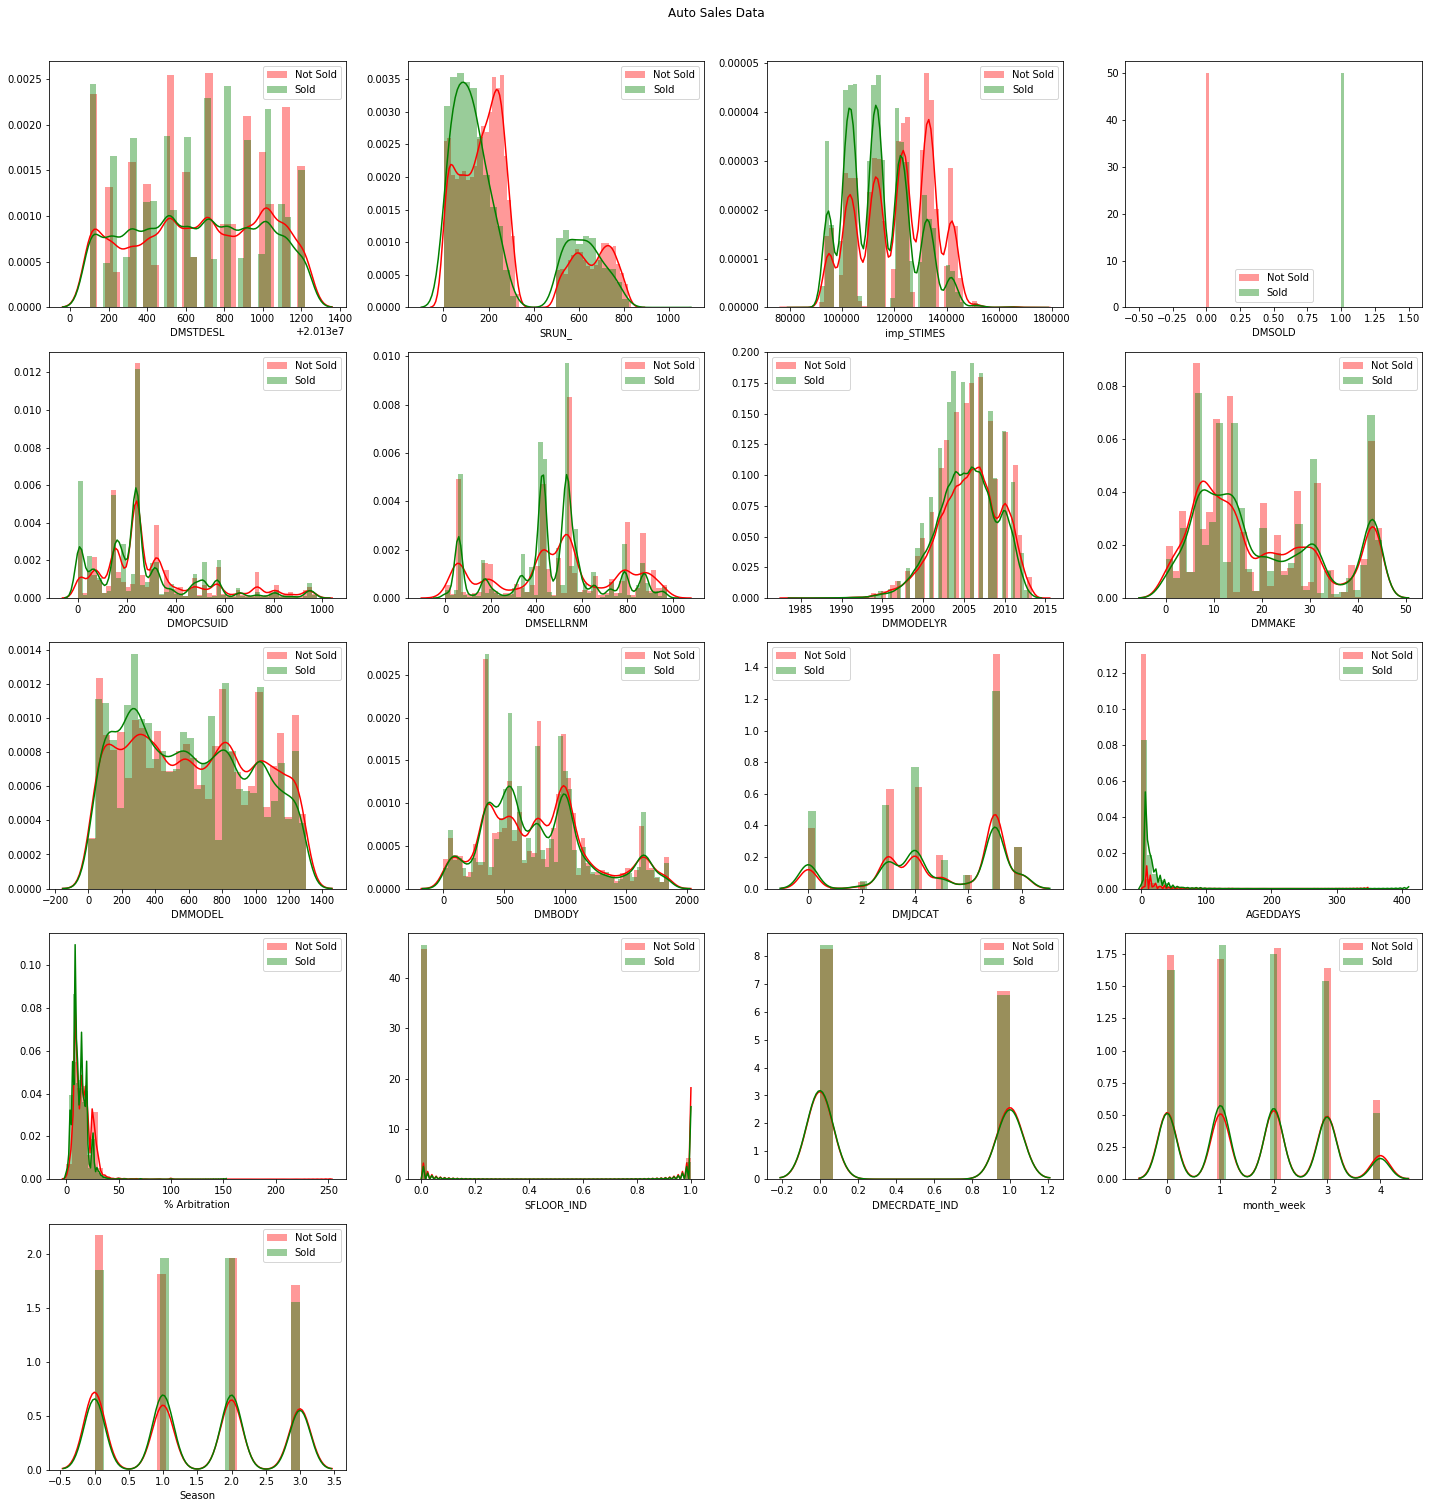

In [34]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in corr_data.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(corr_data[i][corr_data['DMSOLD']==0], color='r', label = 'Not Sold')
    sns.distplot(corr_data[i][corr_data['DMSOLD']==1], color='g', label = 'Sold')
    plt.legend(loc='best')
fig.suptitle('Auto Sales Data')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [35]:
categorical_reference = data[list(set(categorical_features) - set(cat_cols_drop))]
for i in list(set(categorical_features)-set(cat_cols_drop)):
    categorical_reference[i+"_encoded"] = corr_data[i]
categorical_reference = categorical_reference[['DMMAKE','DMMAKE_encoded','DMBODY','DMBODY_encoded','SFLOOR_IND','SFLOOR_IND_encoded','DMSELLRNM','DMSELLRNM_encoded','DMECRDATE_IND','DMECRDATE_IND_encoded','DMOPCSUID','DMOPCSUID_encoded','DMJDCAT','DMJDCAT_encoded','Season','Season_encoded','month_week','month_week_encoded', 'DMMODEL','DMMODEL_encoded']]

C:\Users\willh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
categorical_reference.columns

Index(['DMMAKE', 'DMMAKE_encoded', 'DMBODY', 'DMBODY_encoded', 'SFLOOR_IND',
       'SFLOOR_IND_encoded', 'DMSELLRNM', 'DMSELLRNM_encoded', 'DMECRDATE_IND',
       'DMECRDATE_IND_encoded', 'DMOPCSUID', 'DMOPCSUID_encoded', 'DMJDCAT',
       'DMJDCAT_encoded', 'Season', 'Season_encoded', 'month_week',
       'month_week_encoded', 'DMMODEL', 'DMMODEL_encoded'],
      dtype='object')

In [37]:
# get results for features
cat_cols = list(set(categorical_features) - set(cat_cols_drop))
data_penult = data[corr_data.columns]
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
all_results, all_cm, all_score, all_columns, all_feature_importances, all_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.617047 (0.008408)
[[3007 1982]
 [1846 3068]]
score:0.6134504695546804
prec_rec:  0.6075247524752475 0.6243386243386243
Running initial XGB
XGB: 0.862124 (0.004351)
[[4381  608]
 [ 738 4176]]
score:0.8640815914369383
prec_rec:  0.8729096989966555 0.8498168498168498
Running initial RF
RF: 0.839073 (0.008085)
[[4448  541]
 [ 960 3954]]
score:0.8484297687569423
prec_rec:  0.8796440489432703 0.8046398046398047


In [40]:
all_feature_importances

,Feature,Importance
4,AGEDDAYS,0.321751
2,imp_STIMES,0.058626
1,SRUN_,0.056110
0,DMSTDESL,0.037485
3,DMMODELYR,0.029812
5,% Arbitration,0.016814
1309,DMECRDATE_IND_Y,0.012231
2337,month_week_3,0.008958
2338,month_week_4,0.008762
2336,month_week_2,0.008248


In [39]:
rfe_features = rfe_feature_selection(X_train, y_train)

KeyboardInterrupt: 

### Take a closer look at AGEDDAYS

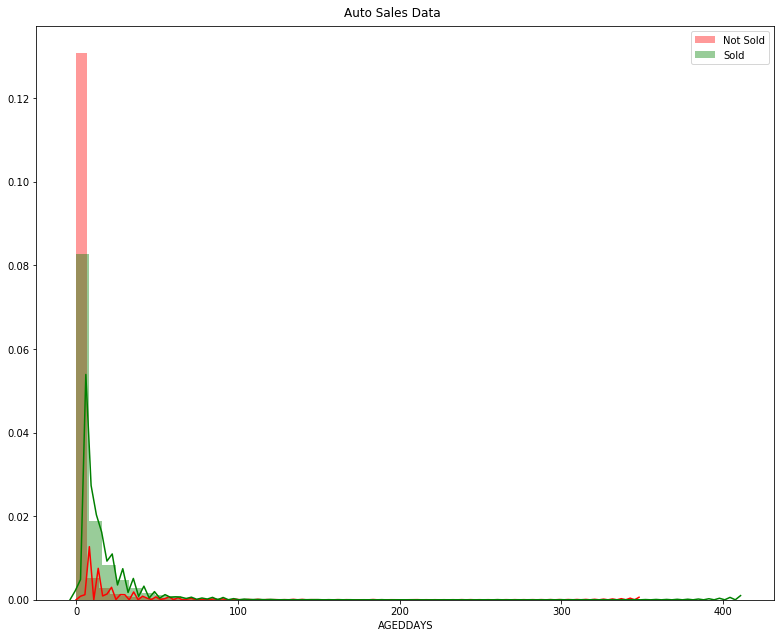

In [41]:
fig, ax = plt.subplots(figsize=(11,9))
sns.distplot(corr_data['AGEDDAYS'][corr_data['DMSOLD']==0], color='r', label = 'Not Sold')
sns.distplot(corr_data['AGEDDAYS'][corr_data['DMSOLD']==1], color='g', label = 'Sold')
plt.legend(loc='best')
fig.suptitle('Auto Sales Data')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [42]:
data_penult = data[['DMSOLD', 'AGEDDAYS']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
AGEDDAYS_results, AGEDDAYS_cm, AGEDDAYS_score, AGEDDAYS_columns, AGEDDAYS_feature_importances, AGEDDAYS_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.731570 (0.009991)
[[4487  515]
 [2214 2687]]
score:0.7244269413309098
prec_rec:  0.8391630231105559 0.5482554580697817
Running initial XGB
XGB: 0.858008 (0.006460)
[[4287  715]
 [ 757 4144]]
score:0.851358174290619
prec_rec:  0.8528503807367771 0.8455417261783309
Running initial RF
RF: 0.857630 (0.006618)
[[4293  709]
 [ 758 4143]]
score:0.8518630717964253
prec_rec:  0.8538746908491344 0.8453376861864925


In [43]:
AGEDDAYS_prec_rec

{'LR': [0.8391630231105559, 0.5482554580697817],
 'XGB': [0.8528503807367771, 0.8455417261783309],
 'RF': [0.8538746908491344, 0.8453376861864925]}

### AGEDDAYS alone explains ~.85 of the data
### lets look at the other features individually

In [45]:
data_penult = data[['DMSOLD', 'imp_STIMES']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
STIMES_results, STIMES_cm, STIMES_score, STIMES_columns, STIMES_feature_importances, STIMES_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.510604 (0.000003)
[[5051    0]
 [4852    0]]
score:0.5100474603655458
prec_rec:  0.0 0.0
Running initial XGB


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


XGB: 0.629393 (0.005472)
[[2706 2345]
 [1321 3531]]
score:0.6298091487428052
prec_rec:  0.6009189925119128 0.7277411376751854
Running initial RF
RF: 0.554156 (0.004288)
[[2873 2178]
 [2163 2689]]
score:0.5616479854589518
prec_rec:  0.552496404355866 0.5542044517724649


In [46]:
data_penult = data[['DMSOLD', 'SRUN_']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
SRUN_results, SRUN_cm, SRUN_score, SRUN_columns, SRUN_feature_importances, SRUN_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.592531 (0.009973)
[[3177 1819]
 [2154 2753]]
score:0.5988084418862971
prec_rec:  0.6021434820647419 0.5610352557570817
Running initial XGB
XGB: 0.625327 (0.010197)
[[2758 2238]
 [1424 3483]]
score:0.6302130667474503
prec_rec:  0.6088096486628212 0.7098023232117383
Running initial RF
RF: 0.616138 (0.008504)
[[2849 2147]
 [1624 3283]]
score:0.6192063011208725
prec_rec:  0.6046040515653776 0.6690442225392297


In [47]:
data_penult = data[['DMSOLD', 'DMSTDESL']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
DMSTDESL_results, DMSTDESL_cm, DMSTDESL_score, DMSTDESL_columns, DMSTDESL_feature_importances, DMSTDESL_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.511008 (0.000052)
[[5035    0]
 [4868    0]]
score:0.5084317883469656
prec_rec:  0.0 0.0
Running initial XGB


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


XGB: 0.534715 (0.008902)
[[2981 2054]
 [2550 2318]]
score:0.5350903766535393
prec_rec:  0.530192131747484 0.4761709120788825
Running initial RF
RF: 0.533755 (0.008826)
[[3263 1772]
 [2833 2035]]
score:0.534989397152378
prec_rec:  0.5345416338324139 0.4180361544782251


In [48]:
data_penult = data[['DMSOLD', 'DMMODELYR']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
DMMODELYR_results, DMMODELYR_cm, DMMODELYR_score, DMMODELYR_columns, DMMODELYR_feature_importances, DMMODELYR_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.506691 (0.000001)
[[5206    0]
 [4697    0]]
score:0.5256992830455418
prec_rec:  0.0 0.0
Running initial XGB


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


XGB: 0.523127 (0.004322)
[[3506 1700]
 [2989 1708]]
score:0.5265071190548318
prec_rec:  0.5011737089201878 0.36363636363636365
Running initial RF
RF: 0.520779 (0.004057)
[[3506 1700]
 [2989 1708]]
score:0.5265071190548318
prec_rec:  0.5011737089201878 0.36363636363636365


In [49]:
data_penult = data[['DMSOLD', '% Arbitration']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
Arbit_results, Arbit_cm, Arbit_score, Arbit_columns, Arbit_feature_importances, Arbit_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.563952 (0.010331)
[[2973 2097]
 [2228 2605]]
score:0.563263657477532
prec_rec:  0.5540195661420672 0.5390026898406787
Running initial XGB
XGB: 0.616289 (0.006064)
[[2268 2802]
 [1020 3813]]
score:0.614056346561648
prec_rec:  0.5764172335600907 0.7889509621353197
Running initial RF
RF: 0.619749 (0.006042)
[[2482 2588]
 [1173 3660]]
score:0.6202160961324851
prec_rec:  0.5857874519846351 0.7572936064556176


In [50]:
data_penult = data[['DMSOLD', 'DMECRDATE_IND']]
cat_cols = ['DMECRDATE_IND']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
DMECRDT_results, DMECRDT_cm, DMECRDT_score, DMECRDT_columns, DMECRDT_feature_importances, DMECRDT_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.509443 (0.000050)
[[5097    0]
 [4806    0]]
score:0.5146925174189639
prec_rec:  0.0 0.0
Running initial XGB


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


XGB: 0.509443 (0.000050)
[[5097    0]
 [4806    0]]
score:0.5146925174189639
prec_rec:  0.0 0.0
Running initial RF


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


RF: 0.509443 (0.000050)
[[5097    0]
 [4806    0]]
score:0.5146925174189639
prec_rec:  0.0 0.0


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
data_penult = data[['DMSOLD', 'month_week']]
cat_cols = ['month_week']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
mweek_results, mweek_cm, mweek_score, mweek_columns, mweek_feature_importances, mweek_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.520450 (0.005752)
[[3773 1202]
 [3705 1223]]
score:0.5044935878016763
prec_rec:  0.5043298969072165 0.2481737012987013
Running initial XGB
XGB: 0.520450 (0.005752)
[[3773 1202]
 [3705 1223]]
score:0.5044935878016763
prec_rec:  0.5043298969072165 0.2481737012987013
Running initial RF
RF: 0.520450 (0.005752)
[[3773 1202]
 [3705 1223]]
score:0.5044935878016763
prec_rec:  0.5043298969072165 0.2481737012987013


In [52]:
data_penult = data[['DMSOLD', 'Season']]
cat_cols = ['Season']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
Season_results, Season_cm, Season_score, Season_columns, Season_feature_importances, Season_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.519844 (0.007376)
[[3880 1229]
 [3561 1233]]
score:0.5163081894375442
prec_rec:  0.5008123476848091 0.2571964956195244
Running initial XGB
XGB: 0.519844 (0.007376)
[[3880 1229]
 [3561 1233]]
score:0.5163081894375442
prec_rec:  0.5008123476848091 0.2571964956195244
Running initial RF
RF: 0.520804 (0.006484)
[[3880 1229]
 [3561 1233]]
score:0.5163081894375442
prec_rec:  0.5008123476848091 0.2571964956195244


In [53]:
data_penult = data[['DMSOLD', 'DMSELLRNM']]
cat_cols = ['DMSELLRNM']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
DMSELLRNM_results, DMSELLRNM_cm, DMSELLRNM_score, DMSELLRNM_columns, DMSELLRNM_feature_importances, DMSELLRNM_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.630024 (0.004417)
[[2557 2528]
 [1227 3591]]
score:0.6208219731394526
prec_rec:  0.5868605981369505 0.7453300124533001
Running initial XGB
XGB: 0.613411 (0.005354)
[[4158  927]
 [2991 1827]]
score:0.6043623144501666
prec_rec:  0.6633986928104575 0.3792029887920299
Running initial RF
RF: 0.626389 (0.005009)
[[2389 2696]
 [1105 3713]]
score:0.6161769160860345
prec_rec:  0.579341550943985 0.7706517227065173


In [54]:
data_penult = data[['DMSOLD', 'DMJDCAT']]
cat_cols = ['DMJDCAT']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
DMJDCAT_results, DMJDCAT_cm, DMJDCAT_score, DMJDCAT_columns, DMJDCAT_feature_importances, DMJDCAT_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.538881 (0.006572)
[[3290 1830]
 [2688 2095]]
score:0.5437746137534081
prec_rec:  0.5337579617834395 0.43800961739494043
Running initial XGB
XGB: 0.539891 (0.005693)
[[3162 1958]
 [2568 2215]]
score:0.542966777744118
prec_rec:  0.5307931943445963 0.4630984737612377
Running initial RF
RF: 0.539083 (0.006563)
[[3517 1603]
 [2921 1862]]
score:0.5431687367464405
prec_rec:  0.5373737373737374 0.38929542128371314


### Top 7 features from 'all' model
AGEDDAYS, imp_STIMES, SRUN_, DMSTDESL, DMMODELYR, % Arbitration, DMECRDATE_IND


In [55]:
all_feature_importances[:7]

,Feature,Importance
4,AGEDDAYS,0.321751
2,imp_STIMES,0.058626
1,SRUN_,0.056110
0,DMSTDESL,0.037485
3,DMMODELYR,0.029812
5,% Arbitration,0.016814
1309,DMECRDATE_IND_Y,0.012231


In [56]:
data_penult = data[['DMSOLD', 'AGEDDAYS', 'imp_STIMES', 'SRUN_', 'DMSTDESL', 'DMMODELYR', '% Arbitration', 'DMECRDATE_IND']]
cat_cols = ['DMECRDATE_IND']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
top_all_results, top_all_cm, top_all_score, top_all_columns, top_all_feature_importances, top_all_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.615280 (0.005413)
[[3019 2065]
 [1709 3110]]
score:0.6189033626173887
prec_rec:  0.6009661835748792 0.6453621083212284
Running initial XGB
XGB: 0.861366 (0.005989)
[[4461  623]
 [ 719 4100]]
score:0.8644855094415833
prec_rec:  0.8680923142070718 0.850798920937954
Running initial RF
RF: 0.860129 (0.004772)
[[4469  615]
 [ 758 4061]]
score:0.8613551449055842
prec_rec:  0.8684773310521814 0.8427059555924465


In [57]:
data_penult = data[['DMSOLD', 'AGEDDAYS', 'imp_STIMES', 'SRUN_', 'DMSTDESL', 'DMMODELYR', '% Arbitration']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
top6_all_results, top6_all_cm, top6_all_score, top6_all_columns, top6_all_feature_importances, top6_all_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.616138 (0.004321)
[[3034 2004]
 [1763 3102]]
score:0.6196102191255175
prec_rec:  0.6075205640423031 0.6376156217882837
Running initial XGB
XGB: 0.860382 (0.005415)
[[4468  570]
 [ 819 4046]]
score:0.8597394728870039
prec_rec:  0.8765164644714039 0.8316546762589928
Running initial RF
RF: 0.859069 (0.005173)
[[4448  590]
 [ 821 4044]]
score:0.8575179238614561
prec_rec:  0.8726801899007337 0.8312435765673176


In [58]:
data_penult = data[['DMSOLD', 'AGEDDAYS', 'imp_STIMES', 'SRUN_', 'DMSTDESL', 'DMMODELYR']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
top5_all_results, top5_all_cm, top5_all_score, top5_all_columns, top5_all_feature_importances, top5_all_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.614623 (0.007893)
[[3023 1974]
 [1799 3107]]
score:0.6190043421185499
prec_rec:  0.6114938004329856 0.6333061557276803
Running initial XGB
XGB: 0.859927 (0.005990)
[[4397  600]
 [ 785 4121]]
score:0.860143390891649
prec_rec:  0.8729082821436136 0.8399918467183041
Running initial RF
RF: 0.850257 (0.004382)
[[4403  594]
 [ 881 4025]]
score:0.8510552357871353
prec_rec:  0.8714007360900627 0.8204239706481858


In [59]:
data_penult = data[['DMSOLD', 'AGEDDAYS', 'imp_STIMES', 'SRUN_', 'DMSTDESL', '% Arbitration']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
top5_all_results, top5_all_cm, top5_all_score, top5_all_columns, top5_all_feature_importances, top5_all_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.615684 (0.010047)
[[3078 2026]
 [1768 3031]]
score:0.6168837725941634
prec_rec:  0.5993672137631006 0.6315899145655345
Running initial XGB
XGB: 0.860331 (0.005672)
[[4497  607]
 [ 808 3991]]
score:0.8571140058568111
prec_rec:  0.8679860809047412 0.8316315899145655
Running initial RF
RF: 0.851545 (0.005096)
[[4468  636]
 [ 831 3968]]
score:0.8518630717964253
prec_rec:  0.8618592528236316 0.826838924775995


In [65]:
data_penult = data[['DMSOLD', 'AGEDDAYS', 'imp_STIMES']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
top2_all_results, top2_all_cm, top2_all_score, top2_all_columns, top2_all_feature_importances, top2_all_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.723238 (0.004240)
[[4560  470]
 [2243 2630]]
score:0.72604261334949
prec_rec:  0.8483870967741935 0.5397085983993434
Running initial XGB
XGB: 0.857075 (0.006108)
[[4369  661]
 [ 766 4107]]
score:0.8559022518428759
prec_rec:  0.8613674496644296 0.8428073055612559
Running initial RF
RF: 0.787922 (0.006885)
[[4050  980]
 [1191 3682]]
score:0.7807735029788953
prec_rec:  0.7897897897897898 0.7555920377590807


### Top 7 features from individual models

In [66]:
data_penult = data[['DMSOLD', 'AGEDDAYS', 'imp_STIMES','SRUN_','% Arbitration','DMSELLRNM','DMSTDESL','Season']]
cat_cols = ['DMSELLRNM','Season']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
top_ind_results, top_ind_cm, top_ind_score, top_ind_columns, top_ind_feature_importances, top_ind_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.616391 (0.006795)
[[2962 2046]
 [1767 3128]]
score:0.6149651620720994
prec_rec:  0.6045612678778508 0.6390194075587334
Running initial XGB
XGB: 0.860609 (0.004805)
[[4382  626]
 [ 767 4128]]
score:0.8593355548823589
prec_rec:  0.8683214135464872 0.8433094994892748
Running initial RF
RF: 0.849096 (0.006112)
[[4359  649]
 [ 833 4062]]
score:0.8503483792790064
prec_rec:  0.8622373169178519 0.8298263534218591


In [67]:
top_ind_feature_importances

,Feature,Importance
0,AGEDDAYS,0.475844
1,imp_STIMES,0.155369
2,SRUN_,0.145086
4,DMSTDESL,0.075153
3,% Arbitration,0.032023
538,DMSELLRNM_LESTER GLENN BUICK,0.005876
63,DMSELLRNM_ALANS AUTOS,0.004304
979,Season_Su,0.004033
980,Season_W,0.003975
978,Season_S,0.003881


In [68]:
data_penult = data[['DMSOLD', 'AGEDDAYS', 'imp_STIMES','SRUN_','DMSTDESL']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
top4_ind_results, top4_ind_cm, top4_ind_score, top4_ind_columns, top4_ind_feature_importances, top4_ind_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.614548 (0.007013)
[[2976 2046]
 [1698 3183]]
score:0.6219327476522266
prec_rec:  0.6087205966724039 0.652120467117394
Running initial XGB
XGB: 0.859927 (0.007476)
[[4402  620]
 [ 808 4073]]
score:0.8558012723417147
prec_rec:  0.867888344342638 0.834460151608277
Running initial RF
RF: 0.845183 (0.007518)
[[4372  650]
 [ 914 3967]]
score:0.8420680601837827
prec_rec:  0.8592159410872862 0.8127432903093629


In [64]:
data['CATxMAKE'] = data['DMJDCAT'] + ' ' + data['DMMAKE']
data_penult = data[['DMSOLD', 'CATxMAKE']]
cat_cols = ['CATxMAKE']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
CATMAKE_results, CATMAKE_cm, CATMAKE_score, CATMAKE_columns, CATMAKE_feature_importances, CATMAKE_prec_rec = get_model_results(X_train, y_train, X_test, y_test)


data['SLRxSTIMES'] = data['DMSELLRNM'] + ' ' + data['imp_STIMES'].map(str)
data_penult = data[['DMSOLD', 'SLRxSTIMES']]
cat_cols = ['SLRxSTIMES']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
SLRxTIMES_results, SLRxTIMES_cm, SLRxTIMES_score, SLRxTIMES_columns, SLRxTIMES_feature_importances, SLRxTIMES_prec_rec = get_model_results(X_train, y_train, X_test, y_test)


data['SFLRxVNMMR'] = data['SFLOOR_IND'] + ' ' + data['VNMMR'].map(str)
data_penult = data[['DMSOLD', 'SFLRxVNMMR']]
cat_cols = ['SFLRxVNMMR']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
SLRTIMES_results, SLRTIMES_cm, SLRTIMES_score, SLRTIMES_columns, SLRTIMES_feature_importances, SLRTIMES_prec_rec = get_model_results(X_train, y_train, X_test, y_test)


data['AGEDxECR'] = data['AGEDDAYS'].map(str) + ' ' + data['DMECRDATE_IND']
data_penult = data[['DMSOLD', 'AGEDxECR']]
cat_cols = ['AGEDxECR']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
AGEECR_results, AGEECR_cm, AGEECR_score, AGEECR_columns, AGEECR_feature_importances, AGEECR_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

data['AGEDxSLR'] = data['AGEDDAYS'].map(str) + ' ' + data['DMSELLRNM']
data_penult = data[['DMSOLD', 'AGEDxSLR']]
cat_cols = ['AGEDxSLR']
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
AGESLR_results, AGESLR_cm, AGESLR_score, AGESLR_columns, AGESLR_feature_importances, AGESLR_prec_rec = get_model_results(X_train, y_train, X_test, y_test)


Running initial models
Running initial LR
LR: 0.553196 (0.007591)
[[3192 1886]
 [2568 2257]]
score:0.550237301827729
prec_rec:  0.5447743181269611 0.4677720207253886
Running initial XGB
XGB: 0.545698 (0.006699)
[[4010 1068]
 [3448 1377]]
score:0.5439765727557306
prec_rec:  0.5631901840490797 0.28538860103626945
Running initial RF
RF: 0.554610 (0.008071)
[[3279 1799]
 [2656 2169]]
score:0.5501363223265677
prec_rec:  0.5466229838709677 0.4495336787564767
Running initial models
Running initial LR
LR: 0.523328 (0.003813)
[[4730  351]
 [4344  478]]
score:0.5259012420478643
prec_rec:  0.5765983112183354 0.0991289921194525
Running initial XGB


KeyboardInterrupt: 

### Scrape the web for more data on vehicles using vin

In [72]:
from bs4 import BeautifulSoup 
import requests

In [73]:
def runExtract(vinNum):
    
    '''
    scrapes car detail by vin and pulls everything within the 'td' tags
    '''
    extract = []
    
    for vin in vinNum:
        subvin = vin[0:10]
        URL = "https://www.uswarranty.com/VinDecoder/Home/VinDetails?vin={}".format(subvin)
        r = requests.get(URL) 
        soup = BeautifulSoup(r.content, 'html5lib') 

        tags = soup.findAll('td') #all "td" tag (table) in a list

        for td in range(len(tags)):
            text = tags[td].text
            text = text.strip('\n')
            text = text.strip('\n')
            print(text)
            extract.append(tuple([vin,text]))
    return  extract

In [ ]:
vinNum=data['SSER17']
scraped = runExtract(vinNum)

In [ ]:
scraped = pd.DataFrame(scraped,columns=['Vin','Scraped'])

In [ ]:
frameSet = {'Vin':[],'Vehicle/Body':[],'FuelLiterCylinder':[],'Carburetion':[],'Transmission':[],
           'DrivingWheels':[],'WheelBaseTireSize':[]}

uniqueVins = scraped['Vin'].drop_duplicates()

for uVins in uniqueVins:
    currscraped = scraped[scraped['Vin']==uVins]
    currscraped.reset_index(inplace=True)
    frameSet['Vin'].append(currscraped['Vin'].iloc[0])
    frameSet['Vehicle/Body'].append(currscraped['Scraped'].iloc[5])
    frameSet['FuelLiterCylinder'].append(currscraped['Scraped'].iloc[7])
    frameSet['Carburetion'].append(currscraped['Scraped'].iloc[9])
    frameSet['Transmission'].append(currscraped['Scraped'].iloc[11])
    frameSet['DrivingWheels'].append(currscraped['Scraped'].iloc[13])
    
    frameSet['WheelBaseTireSize'].append(currscraped['Scraped'].iloc[15])

In [ ]:
adjSet = pd.DataFrame.from_dict(frameSet)
adjSet.head(10)

In [ ]:
adjSet.to_csv(r'C:\Users\willh\Cox_Manheim_Analysis\scraped.csv')

In [78]:
scraped = pd.read_csv(r'C:\Users\willh\Cox_Manheim_Analysis\scraped.csv')

In [79]:
origsize = data.shape[0]
origsize

49511

In [80]:
data['SSER17'] = raw_data['SSER17']

In [81]:
data=data.merge(scraped,left_on='SSER17',right_on='Vin')
newsize = data.shape[0]
'''
if error, we have duplicates in the scraped set
'''
assert origsize==newsize

In [82]:
data.columns

Index(['DMSTDESL', 'DMMONTH', 'DMSALWK', 'SSALE_', 'SLANE_', 'SRUN_',
       'imp_STIMES', 'DMSOLD', 'DMOPCSUID', 'DMSELLRNM', 'DMMODELYR', 'DMMAKE',
       'DMMODEL', 'DMBODY', 'SMILES', 'DMJDCAT', 'AGEDDAYS', 'VNMMR',
       '% Arbitration', 'SFLOOR_IND', 'DMECRDATE_IND', 'month_week', 'Season',
       'CATxMAKE', 'SLRxSTIMES', 'SSER17', 'Vin', 'Vehicle/Body',
       'FuelLiterCylinder', 'Carburetion', 'Transmission', 'DrivingWheels',
       'WheelBaseTireSize'],
      dtype='object')

In [83]:
data.head()

,DMSTDESL,DMMONTH,DMSALWK,SSALE_,SLANE_,SRUN_,imp_STIMES,DMSOLD,DMOPCSUID,DMSELLRNM,...,CATxMAKE,SLRxSTIMES,SSER17,Vin,Vehicle/Body,FuelLiterCylinder,Carburetion,Transmission,DrivingWheels,WheelBaseTireSize
0,20130102,1,1,1,3,501,92831,0,5260865,HAMILTON HONDA,...,LUXURY CAR SAAB,HAMILTON HONDA 92831,YS3FD46Y871134139,YS3FD46Y871134139,Passenger / Sedan 4 Door\n,Gas / 2.0 / 4 \n,Turbo Fuel Injected\n,"5 Speed Manual, Optional: 5 Speed ...",Front\n,10530000/ 16R215\n
1,20130109,1,2,2,3,760,134634,1,5260865,HAMILTON HONDA,...,LUXURY CAR SAAB,HAMILTON HONDA 134634,YS3FD46Y871134139,YS3FD46Y871134139,Passenger / Sedan 4 Door\n,Gas / 2.0 / 4 \n,Turbo Fuel Injected\n,"5 Speed Manual, Optional: 5 Speed ...",Front\n,10530000/ 16R215\n
2,20130102,1,1,1,3,502,124108,0,5260865,HAMILTON HONDA,...,PICKUP HONDA,HAMILTON HONDA 124108,5FPYK1F45BB001220,5FPYK1F45BB001220,Truck / Crew Pickup\n,Gas / 3.5 / 6 \n,Fuel Injection\n,5 Speed Auto/Od\n,4X4\n,12200000/ \n
3,20130109,1,2,2,3,761,134720,1,5260865,HAMILTON HONDA,...,PICKUP HONDA,HAMILTON HONDA 134720,5FPYK1F45BB001220,5FPYK1F45BB001220,Truck / Crew Pickup\n,Gas / 3.5 / 6 \n,Fuel Injection\n,5 Speed Auto/Od\n,4X4\n,12200000/ \n
4,20130102,1,1,1,3,503,120221,0,5260865,HAMILTON HONDA,...,VAN HONDA,HAMILTON HONDA 120221,5FNRL3H7XAB039067,5FNRL3H7XAB039067,Truck / Sports Van\n,Gas / 3.5 / 6 \n,Fuel Injection\n,5 Speed Auto\n,Front\n,11810000/ \n


In [84]:
split = data['FuelLiterCylinder'].str.split('/')
sec1 = [i[0].lstrip().rstrip() for i in split]
sec2 = [i[1].lstrip().rstrip() for i in split]
data['FeulType']=sec1

In [85]:
data['EngineSize']=sec2
data['EngineSize']=[0 if x =='' else x for x in data['EngineSize']]

In [89]:
data['DrivingWheels'].isnull().sum()

0

In [90]:
data['DrivingWheels'] = data['DrivingWheels'].str.strip('\n')
data['DrivingWheels']= data['DrivingWheels'].str.rstrip()
data['DrivingWheels']= data['DrivingWheels'].str.lstrip()

#data['DrivingWheels']=['AWD' if x =='' else x for x in data['DrivingWheels']]

In [92]:
data['FeulType'] = ['Gas' if i not in ['Diesel','Flexible fuel','Gas','Hybrid engine'] else i for i in data['FeulType']]

In [93]:
data['EngineSize']=data['EngineSize'].astype(float)

In [95]:
data.columns

Index(['DMSTDESL', 'DMMONTH', 'DMSALWK', 'SSALE_', 'SLANE_', 'SRUN_',
       'imp_STIMES', 'DMSOLD', 'DMOPCSUID', 'DMSELLRNM', 'DMMODELYR', 'DMMAKE',
       'DMMODEL', 'DMBODY', 'SMILES', 'DMJDCAT', 'AGEDDAYS', 'VNMMR',
       '% Arbitration', 'SFLOOR_IND', 'DMECRDATE_IND', 'month_week', 'Season',
       'CATxMAKE', 'SLRxSTIMES', 'SSER17', 'Vin', 'Vehicle/Body',
       'FuelLiterCylinder', 'Carburetion', 'Transmission', 'DrivingWheels',
       'WheelBaseTireSize', 'FeulType', 'EngineSize'],
      dtype='object')

In [120]:
data.iloc[:,-8:]

,Vehicle/Body,FuelLiterCylinder,Carburetion,Transmission,DrivingWheels,WheelBaseTireSize,FeulType,EngineSize
0,Passenger / Sedan 4 Door\n,Gas / 2.0 / 4 \n,Turbo Fuel Injected\n,"5 Speed Manual, Optional: 5 Speed ...",Front,10530000/ 16R215\n,Gas,2.0
1,Passenger / Sedan 4 Door\n,Gas / 2.0 / 4 \n,Turbo Fuel Injected\n,"5 Speed Manual, Optional: 5 Speed ...",Front,10530000/ 16R215\n,Gas,2.0
2,Truck / Crew Pickup\n,Gas / 3.5 / 6 \n,Fuel Injection\n,5 Speed Auto/Od\n,4X4,12200000/ \n,Gas,3.5
3,Truck / Crew Pickup\n,Gas / 3.5 / 6 \n,Fuel Injection\n,5 Speed Auto/Od\n,4X4,12200000/ \n,Gas,3.5
4,Truck / Sports Van\n,Gas / 3.5 / 6 \n,Fuel Injection\n,5 Speed Auto\n,Front,11810000/ \n,Gas,3.5
5,Truck / Sports Van\n,Gas / 3.5 / 6 \n,Fuel Injection\n,5 Speed Auto\n,Front,11810000/ \n,Gas,3.5
6,Passenger / Coupe\n,Gas / 2.7 / 6 \n,Fuel Injection\n,"5 Speed Manual, Optional: 4 Speed ...",Front,09960000/ 17R215\n,Gas,2.7
7,Truck / 4 Door Wagon/Sport Utility...,Gas / 4.0 / 6 \n,Fuel Injection\n,"5 Speed Auto, Optional: 6 Speed Au...",4X4,11370000/ \n,Gas,4.0
8,Passenger / Coupe\n,Gas / 4.0 / 6 \n,Fuel Injection\n,"5 Speed Manual/Od, Optional: 4 Spe...",Rear wheel,10710000/ 16R215\n,Gas,4.0
9,Passenger / Sedan 4 Door\n,Gas / 3.5 / 6 \n,Fuel Injection\n,4 Speed Auto/Od\n,Front,10630000/ 16R215\n,Gas,3.5


In [118]:
cat_cols=data.iloc[:,-8:].columns.values.tolist()
cat_cols
data_penult_cols = cat_cols
data_penult.append('DMSOLD')
data_penult
data_penult = data[['DMSOLD', 'AGEDDAYS', 'imp_STIMES']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
grid_search_results = grid_search(X_train, y_train)

['Vehicle/Body',
 'FuelLiterCylinder',
 'Carburetion',
 'Transmission',
 'DrivingWheels',
 'WheelBaseTireSize',
 'FeulType',
 'EngineSize',
 'DMSOLD']

In [128]:
cat_cols = ['FuelLiterCylinder']
data_penult = data[['DMSOLD', 'FuelLiterCylinder']]
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
FLC_results, FLC_cm, FLC_score, FLC_columns, FLC_feature_importances, FLC_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.540648 (0.006662)
[[3488 1533]
 [2943 1939]]
score:0.5480157528021812
prec_rec:  0.5584677419354839 0.39717328963539533
Running initial XGB
XGB: 0.543552 (0.006123)
[[3878 1143]
 [3340 1542]]
score:0.5473088962940523
prec_rec:  0.5743016759776536 0.31585415813191314
Running initial RF
RF: 0.542416 (0.006612)
[[3415 1606]
 [2881 2001]]
score:0.5469049782894072
prec_rec:  0.5547546437482672 0.4098730028676772


In [129]:
cat_cols = ['Carburetion']
data_penult = data[['DMSOLD', 'Carburetion']]
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
Carb_results, Carb_cm, FLC_score, Carb_columns, Carb_feature_importances, Carb_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.509569 (0.001041)
[[5084   22]
 [4773   24]]
score:0.5158032919317379
prec_rec:  0.5217391304347826 0.0050031269543464665
Running initial XGB
XGB: 0.509569 (0.001041)
[[5084   22]
 [4773   24]]
score:0.5158032919317379
prec_rec:  0.5217391304347826 0.0050031269543464665
Running initial RF
RF: 0.509392 (0.000931)
[[5084   22]
 [4773   24]]
score:0.5158032919317379
prec_rec:  0.5217391304347826 0.0050031269543464665


In [130]:
cat_cols = ['Transmission']
data_penult = data[['DMSOLD', 'Transmission']]
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
Trans_results, Trans_cm, Trans_score, Trans_columns, Trans_feature_importances, Trans_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.535977 (0.005671)
[[3402 1676]
 [2830 1995]]
score:0.5449863677673432
prec_rec:  0.5434486515935713 0.41347150259067356
Running initial XGB
XGB: 0.536457 (0.005488)
[[3965 1113]
 [3409 1416]]
score:0.543370695748763
prec_rec:  0.5599051008303677 0.29347150259067356
Running initial RF
RF: 0.534008 (0.004095)
[[3384 1694]
 [2839 1986]]
score:0.5422599212359891
prec_rec:  0.5396739130434782 0.4116062176165803


In [131]:
cat_cols = ['DrivingWheels']
data_penult = data[['DMSOLD', 'DrivingWheels']]
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
DrWheels_results, DrWheels_cm, DrWheels_score, DrWheels_columns, DrWheels_feature_importances, DrWheels_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.538275 (0.008790)
[[3024 2050]
 [2452 2377]]
score:0.5453902857719883
prec_rec:  0.5369324599051276 0.49223441706357424
Running initial XGB
XGB: 0.538224 (0.008780)
[[3024 2050]
 [2452 2377]]
score:0.5453902857719883
prec_rec:  0.5369324599051276 0.49223441706357424
Running initial RF
RF: 0.538275 (0.008790)
[[3024 2050]
 [2452 2377]]
score:0.5453902857719883
prec_rec:  0.5369324599051276 0.49223441706357424


In [132]:
cat_cols = ['FeulType']
data_penult = data[['DMSOLD', 'FeulType']]
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
FuelType_results, FuelType_cm, FuelType_score, FuelType_columns, FuelType_feature_importances, FuelType_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.510856 (0.000003)
[[5041    0]
 [4862    0]]
score:0.5090376653539331
prec_rec:  0.0 0.0
Running initial XGB


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


XGB: 0.510856 (0.000003)
[[5041    0]
 [4862    0]]
score:0.5090376653539331
prec_rec:  0.0 0.0
Running initial RF


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


RF: 0.510856 (0.000003)
[[5041    0]
 [4862    0]]
score:0.5090376653539331
prec_rec:  0.0 0.0


C:\Users\willh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [133]:
cat_cols = ['EngineSize']
data_penult = data[['DMSOLD', 'EngineSize']]
X_train, X_test, y_train, y_test = prep_data(data_penult, cat_cols)
EngSz_results, EngSz_cm, EngSz_score, EngSz_columns, EngSz_feature_importances, EngSz_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.537669 (0.008332)
[[3337 1771]
 [2749 2046]]
score:0.5435726547510855
prec_rec:  0.5360230547550432 0.4266944734098019
Running initial XGB
XGB: 0.539183 (0.008398)
[[3664 1444]
 [3031 1764]]
score:0.5481167323033425
prec_rec:  0.5498753117206983 0.3678832116788321
Running initial RF
RF: 0.539007 (0.009103)
[[3295 1813]
 [2712 2083]]
score:0.5430677572452792
prec_rec:  0.5346509240246407 0.4344108446298227


### Scraped features aren't very helpful

### Make 'sold percentage' features

In [150]:
makes = data.pivot_table('month_week',index = ['DMMAKE'],columns = ['DMSOLD'], aggfunc=len).fillna(0).reset_index()
makes['MAKE_sell_pct'] = makes[1]/(makes[0]+makes[1])*100
makes = makes[['DMMAKE','MAKE_sell_pct']]
data = pd.merge(data, makes, on='DMMAKE')

models = data.pivot_table('month_week',index = ['DMMODEL'],columns = ['DMSOLD'], aggfunc=len).fillna(0).reset_index()
models['MODEL_sell_pct'] = models[1]/(models[0]+models[1])*100
models = models[['DMMODEL','MODEL_sell_pct']]
data = pd.merge(data, models, on='DMMODEL')

seller = data.pivot_table('month_week',index = ['DMSELLRNM'],columns = ['DMSOLD'], aggfunc=len).fillna(0).reset_index()
seller['SELLRNM_sell_pct'] = seller[1]/(seller[0]+seller[1])*100
seller = seller[['DMSELLRNM','SELLRNM_sell_pct']]
data = pd.merge(data, seller, on='DMSELLRNM')

In [154]:
data_penult = data[['DMSOLD', 'MAKE_sell_pct']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
MKsellpct_results, MKsellpct_cm, MKsellpct_score, MKsellpct_columns, MKsellpct_feature_importances, MKsellpct_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.539587 (0.006917)
[[2821 2179]
 [2417 2486]]
score:0.5358982126628294
prec_rec:  0.5329046087888532 0.5070365082602488
Running initial XGB
XGB: 0.537366 (0.007243)
[[2821 2179]
 [2417 2486]]
score:0.5358982126628294
prec_rec:  0.5329046087888532 0.5070365082602488
Running initial RF
RF: 0.536305 (0.007510)
[[3359 1641]
 [2955 1948]]
score:0.5358982126628294
prec_rec:  0.5427695736974087 0.39730777075260043


In [152]:
data_penult = data[['DMSOLD', 'MODEL_sell_pct']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
MDLsellpct_results, MDLsellpct_cm, MDLsellpct_score, MDLsellpct_columns, MDLsellpct_feature_importances, MDLsellpct_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.595562 (0.007082)
[[3221 1892]
 [2001 2789]]
score:0.6068868019791982
prec_rec:  0.5958128604998932 0.5822546972860125
Running initial XGB
XGB: 0.594476 (0.006927)
[[3127 1986]
 [1932 2858]]
score:0.6043623144501666
prec_rec:  0.5900082576383154 0.5966597077244259
Running initial RF
RF: 0.579883 (0.006771)
[[3157 1956]
 [2112 2678]]
score:0.5892153892759769
prec_rec:  0.5779024600776866 0.5590814196242171


In [153]:
data_penult = data[['DMSOLD', 'SELLRNM_sell_pct']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
SLLRsellpct_results, SLLRsellpct_cm, SLLRsellpct_score, SLLRsellpct_columns, SLLRsellpct_feature_importances, SLLRsellpct_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.636715 (0.006430)
[[2495 2533]
 [1056 3819]]
score:0.6375845703322226
prec_rec:  0.601227959697733 0.7833846153846153
Running initial XGB
XGB: 0.635326 (0.006750)
[[2301 2727]
 [ 874 4001]]
score:0.6363728163182873
prec_rec:  0.5946789536266349 0.8207179487179487
Running initial RF
RF: 0.632675 (0.006651)
[[2314 2714]
 [ 898 3977]]
score:0.6352620418055135
prec_rec:  0.5943805111343596 0.8157948717948718


In [161]:
data_penult = data[['DMSOLD', 'AGEDDAYS','SELLRNM_sell_pct']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
AGEDsellpct_results, AGEDsellpct_cm, AGEDsellpct_score, AGEDsellpct_columns, AGEDsellpct_feature_importances, AGEDsellpct_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.770703 (0.007507)
[[4070  949]
 [1327 3557]]
score:0.7701706553569625
prec_rec:  0.7893919218819352 0.7282964782964783
Running initial XGB
XGB: 0.864725 (0.007118)
[[4418  601]
 [ 750 4134]]
score:0.863576693931132
prec_rec:  0.8730728616684266 0.8464373464373465
Running initial RF
RF: 0.861442 (0.006738)
[[4425  594]
 [ 799 4085]]
score:0.8593355548823589
prec_rec:  0.8730497969651635 0.8364045864045864


In [163]:
data_penult = data[['DMSOLD', 'AGEDDAYS','MODEL_sell_pct']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
AGEDsellpct_results, AGEDsellpct_cm, AGEDsellpct_score, AGEDsellpct_columns, AGEDsellpct_feature_importances, AGEDsellpct_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.719148 (0.005727)
[[4125  948]
 [1790 3040]]
score:0.7235181258204585
prec_rec:  0.7622868605817452 0.629399585921325
Running initial XGB
XGB: 0.858009 (0.005001)
[[4404  669]
 [ 725 4105]]
score:0.8592345753811976
prec_rec:  0.8598659405111018 0.849896480331263
Running initial RF
RF: 0.842002 (0.004177)
[[4471  602]
 [ 937 3893]]
score:0.8445925477128143
prec_rec:  0.8660734149054505 0.8060041407867495


In [160]:
data_penult = data[['DMSOLD', 'AGEDDAYS','SELLRNM_sell_pct','imp_STIMES']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
AGEDTIMESsellpct_results, AGEDTIMESsellpct_cm, AGEDTIMESsellpct_score, AGEDTIMESsellpct_columns, AGEDTIMESsellpct_feature_importances, AGEDTIMESsellpct_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.747248 (0.008214)
[[3917 1130]
 [1313 3543]]
score:0.7533070786630314
prec_rec:  0.7581853199229617 0.7296128500823723
Running initial XGB
XGB: 0.864674 (0.005510)
[[4475  572]
 [ 775 4081]]
score:0.863980611935777
prec_rec:  0.8770685579196218 0.8404036243822076
Running initial RF
RF: 0.830918 (0.004418)
[[4258  789]
 [ 898 3958]]
score:0.8296475815409472
prec_rec:  0.8337897619549189 0.8150741350906096


In [159]:
data_penult = data[['DMSOLD', 'AGEDDAYS','SELLRNM_sell_pct','% Arbitration']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
AGEDARBsellpct_results, AGEDARBsellpct_cm, AGEDARBsellpct_score, AGEDARBsellpct_columns, AGEDARBsellpct_feature_importances, AGEDARBsellpct_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.760049 (0.005786)
[[4020 1049]
 [1283 3551]]
score:0.7645158032919317
prec_rec:  0.7719565217391304 0.7345883326437733
Running initial XGB
XGB: 0.863740 (0.005296)
[[4469  600]
 [ 697 4137]]
score:0.8690295869938403
prec_rec:  0.8733375554148195 0.8558129913115432
Running initial RF
RF: 0.859070 (0.007804)
[[4497  572]
 [ 796 4038]]
score:0.8618600424113905
prec_rec:  0.8759219088937094 0.8353330575093091


In [162]:
data_penult = data[['DMSOLD', 'AGEDDAYS','SELLRNM_sell_pct','MODEL_sell_pct']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
SLLRMDLsellpct_results, SLLRMDLsellpct_cm, SLLRMDLsellpct_score, SLLRMDLsellpct_columns, SLLRMDLsellpct_feature_importances, SLLRMDLsellpct_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.764972 (0.008546)
[[4000 1034]
 [1289 3580]]
score:0.7654246188023831
prec_rec:  0.775899436497616 0.7352639145615116
Running initial XGB
XGB: 0.866845 (0.004859)
[[4448  586]
 [ 744 4125]]
score:0.8656972634555186
prec_rec:  0.8756102738272129 0.8471965495995071
Running initial RF
RF: 0.846268 (0.005037)
[[4340  694]
 [ 841 4028]]
score:0.8449964657174593
prec_rec:  0.8530283778060144 0.8272745943725611


### Hyperparameter selection with grid search

#### 1st Model

In [73]:
data_penult = data[['DMSOLD', 'AGEDDAYS', 'imp_STIMES']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
grid_search_results = grid_search(X_train, y_train)

Running XGB Grid Search
Completed running all grid search
Running RF Grid Search
Completed running all grid search


In [74]:
grid_search_results

{'XGB': [0.8563674005251465, {'learning_rate': 0.03, 'n_estimators': 100}],
 'RF': [0.7830741264391032, {'criterion': 'gini', 'n_estimators': 20}]}

In [75]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

xgbClassifier = XGBClassifier(learning_rate = 0.03, n_estimators=100)
cv_results = cross_val_score(xgbClassifier, X_train, y_train, cv=kfold, scoring='accuracy')

xgbClassifier.fit(X_train, y_train)
y_pred = xgbClassifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
class_score = xgbClassifier.score(X_test, y_test)

In [76]:
print('classifier score: ', round(class_score,3))
print('cv results- mean and std:', round(cv_results.mean(),3),round(cv_results.std(),3))
print("confusion matrix: \n",cm)
print("classification report: \n",class_report)
print('precision: ',round(prec,3))
print('recall: ',round(rec,3))

classifier score:  0.859
cv results- mean and std: 0.856 0.005
confusion matrix: 
 [[4446  643]
 [ 758 4056]]
classification report: 
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      5089
           1       0.86      0.84      0.85      4814

   micro avg       0.86      0.86      0.86      9903
   macro avg       0.86      0.86      0.86      9903
weighted avg       0.86      0.86      0.86      9903

precision:  0.863
recall:  0.843


#### 2nd Model

In [168]:
data_penult = data[['DMSOLD', 'AGEDDAYS','SELLRNM_sell_pct']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
grid_search_results2 = grid_search(X_train, y_train)

Running XGB Grid Search
Completed running all grid search
Running RF Grid Search
Completed running all grid search


In [169]:
grid_search_results2

{'XGB': [0.8652292466168451, {'learning_rate': 0.1, 'n_estimators': 400}],
 'RF': [0.862527772167239, {'criterion': 'gini', 'n_estimators': 60}]}

In [170]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

xgbClassifier = XGBClassifier(learning_rate = 0.1, n_estimators=400)
cv_results = cross_val_score(xgbClassifier, X_train, y_train, cv=kfold, scoring='accuracy')

xgbClassifier.fit(X_train, y_train)
y_pred = xgbClassifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
class_score = xgbClassifier.score(X_test, y_test)

In [171]:
print('classifier score: ', round(class_score,3))
print('cv results- mean and std:', round(cv_results.mean(),3),round(cv_results.std(),3))
print("confusion matrix: \n",cm)
print("classification report: \n",class_report)
print('precision: ',round(prec,3))
print('recall: ',round(rec,3))

classifier score:  0.864
cv results- mean and std: 0.865 0.006
confusion matrix: 
 [[4431  667]
 [ 679 4126]]
classification report: 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      5098
           1       0.86      0.86      0.86      4805

   micro avg       0.86      0.86      0.86      9903
   macro avg       0.86      0.86      0.86      9903
weighted avg       0.86      0.86      0.86      9903

precision:  0.861
recall:  0.859


#### 3rd Model

In [187]:
data_penult = data[['DMSOLD', 'SELLRNM_sell_pct','MODEL_sell_pct']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
pct_results, pct_cm, pct_score, pct_columns, pct_feature_importances, pct_prec_rec = get_model_results(X_train, y_train, X_test, y_test)

Running initial models
Running initial LR
LR: 0.672566 (0.005494)
[[3207 1830]
 [1480 3386]]
score:0.6657578511562153
prec_rec:  0.6491564417177914 0.6958487464036169
Running initial XGB
XGB: 0.670294 (0.006225)
[[3285 1752]
 [1548 3318]]
score:0.6667676461678279
prec_rec:  0.6544378698224852 0.6818742293464858
Running initial RF
RF: 0.648404 (0.006601)
[[3405 1632]
 [1857 3009]]
score:0.647682520448349
prec_rec:  0.6483516483516484 0.6183723797780518


In [197]:
data_penult = data[['DMSOLD', 'imp_STIMES','SELLRNM_sell_pct']]
X_train, X_test, y_train, y_test = prep_data(data_penult)
grid_search_results3 = grid_search(X_train, y_train)

Running XGB Grid Search
Completed running all grid search
Running RF Grid Search
Completed running all grid search


In [198]:
grid_search_results3

{'XGB': [0.6542617652999394, {'learning_rate': 0.1, 'n_estimators': 300}],
 'RF': [0.5952080387800445, {'criterion': 'gini', 'n_estimators': 10}]}

In [199]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

xgbClassifier = XGBClassifier(learning_rate = 0.1, n_estimators=300)
cv_results = cross_val_score(xgbClassifier, X_train, y_train, cv=kfold, scoring='accuracy')

xgbClassifier.fit(X_train, y_train)
y_pred = xgbClassifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
class_score = xgbClassifier.score(X_test, y_test)

In [200]:
print('classifier score: ', round(class_score,3))
print('cv results- mean and std:', round(cv_results.mean(),3),round(cv_results.std(),3))
print("confusion matrix: \n",cm)
print("classification report: \n",class_report)
print('precision: ',round(prec,3))
print('recall: ',round(rec,3))

classifier score:  0.653
cv results- mean and std: 0.654 0.004
confusion matrix: 
 [[2950 2060]
 [1374 3519]]
classification report: 
               precision    recall  f1-score   support

           0       0.68      0.59      0.63      5010
           1       0.63      0.72      0.67      4893

   micro avg       0.65      0.65      0.65      9903
   macro avg       0.66      0.65      0.65      9903
weighted avg       0.66      0.65      0.65      9903

precision:  0.631
recall:  0.719
